In [14]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")



In [15]:
# --- Load & prep (standalone-safe) ---
df = pd.read_excel(r"C:\Users\SUSHIL KUMAR\Desktop\retailsales_analysis\data\Online Retail.xlsx")
df = df.dropna(subset=['CustomerID'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']



In [16]:
# ✅ Correct Monthly Revenue Calculation (No .to_period())
rev_m = (
    df.set_index('InvoiceDate')
      .resample('M')['TotalPrice']
      .sum()
)



In [17]:
# Optional: Fill missing months with 0 (rare case)
rev_m = rev_m.asfreq('M').fillna(0.0)

print("\nMonthly Revenue Preview:")
print(rev_m.head())




Monthly Revenue Preview:
InvoiceDate
2010-12-31    572713.890
2011-01-31    569445.040
2011-02-28    447137.350
2011-03-31    595500.760
2011-04-30    469200.361
Freq: ME, Name: TotalPrice, dtype: float64


In [18]:
# --- Train / Test split ---
test_h = 3
train = rev_m[:-test_h]
test = rev_m[-test_h:]

# --- SARIMAX Model ---
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                 enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# --- Forecast ---
fc = res.forecast(steps=test_h)
fc.index = test.index  # align index



In [19]:
# --- Metrics ---
mae = mean_absolute_error(test, fc)
rmse = mean_squared_error(test, fc)**0.5   # works on all sklearn versions

print(f"\nMAE: {mae:.2f} | RMSE: {rmse:.2f}")




MAE: 370638.09 | RMSE: 489131.75


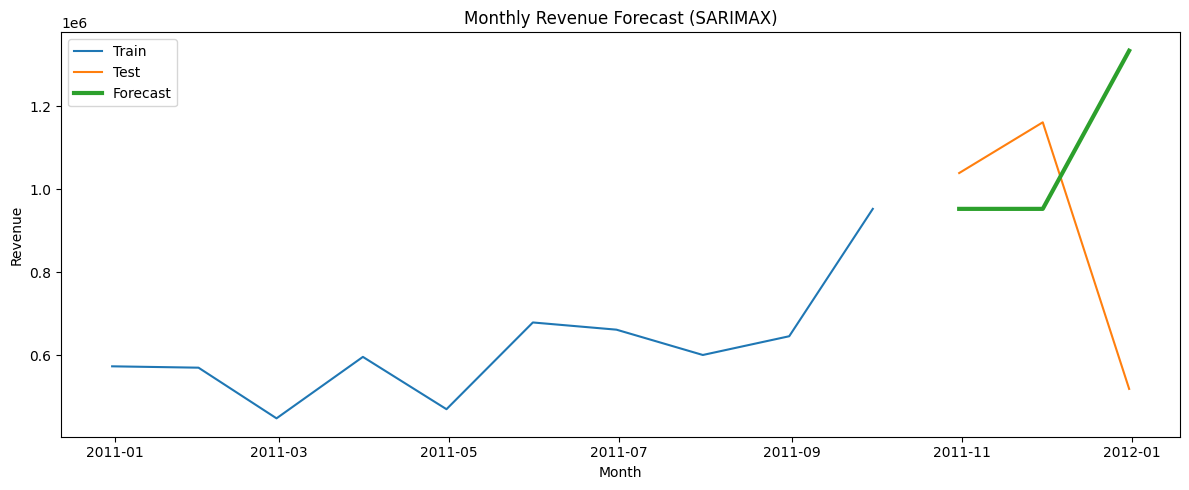

In [20]:
# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(fc.index, fc, label='Forecast', linewidth=3)
plt.title("Monthly Revenue Forecast (SARIMAX)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()



In [21]:
# --- Future Forecast (Next 6 Months) ---
full_model = SARIMAX(rev_m, order=(1,1,1), seasonal_order=(1,1,1,12),
                     enforce_stationarity=False, enforce_invertibility=False)
full_res = full_model.fit(disp=False)

future_fc = full_res.forecast(steps=6)

print("\nNext 6 Months Forecast:")
print(future_fc)



Next 6 Months Forecast:
2012-01-31    514923.940
2012-02-29    392616.250
2012-03-31    540979.660
2012-04-30    414679.261
2012-05-31    624073.460
2012-06-30    606692.590
Freq: ME, Name: predicted_mean, dtype: float64
